# Ford GoBike Data Analysis
## by Jozo Frankovic

## Investigation Overview

> Following my analysis of the Ford GoBike dataset, I have some made some interesting observations which touch on whether you're more of a weekend biker or a Netflix + Chill kind of person, how you commute, and how COVID-19 may have brought the wheels to a sudden halt for a fast moving bike share service. Interested? Read on. 

## Dataset Overview

> Ford GoBike is a regional public bicycle sharing system in the San Francisco Bay Area, California. Beginning operation in August 29th 2013 as Bay Area Bike Share, the Ford GoBike system currently has over 2,600 bicycles in 262 stations across San Francisco, East Bay and San Jose. This data set includes information about individual rides made in a bike-sharing system covering the San Francisco Bay area. 

In [1]:
# Import all packages and set plots to be embedded inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as tick
import seaborn as sns
import missingno as mn
from requests import get
from io import BytesIO
from zipfile import ZipFile
import os 
import datetime
import math
import calendar
import glob

%matplotlib inline


In [2]:
# Load in the dataset into a pandas DataFrame

df_clean = pd.read_csv('data_clean.csv', low_memory=False)
df_clean.head()


,duration_sec,start_time,end_time,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,user_type,start_time_month_name,start_time_month,start_time_weekday,start_time_day,start_time_hour,start_time_year_month,start_time_year,duration_minute
0,598,2018-02-28 23:59:47.097,2018-03-01 00:09:45.187,284.0,37.784872,-122.400876,114.0,37.764478,-122.402570,1035,Subscriber,February,2,Wed,28,23,18-02,2018,9.966667
1,943,2018-02-28 23:21:16.495,2018-02-28 23:36:59.974,6.0,37.804770,-122.403234,324.0,37.788300,-122.408531,1673,Customer,February,2,Wed,28,23,18-02,2018,15.716667
2,18587,2018-02-28 18:20:55.190,2018-02-28 23:30:42.925,93.0,37.770407,-122.391198,15.0,37.795392,-122.394203,3498,Customer,February,2,Wed,28,18,18-02,2018,309.783333
3,18558,2018-02-28 18:20:53.621,2018-02-28 23:30:12.450,93.0,37.770407,-122.391198,15.0,37.795392,-122.394203,3129,Customer,February,2,Wed,28,18,18-02,2018,309.300000
4,885,2018-02-28 23:15:12.858,2018-02-28 23:29:58.608,308.0,37.336802,-121.894090,297.0,37.322980,-121.887931,1839,Subscriber,February,2,Wed,28,23,18-02,2018,14.750000


In [3]:
# Set sns styles 

sns.set_style('whitegrid')
sns.set_context("talk")
sns.set(font_scale=1.25)


In [5]:
# Function for ticks to be more easily read

def transform_axis_format(tick_val, pos):
    if tick_val >= 1000:
        val = int(tick_val/1000)
        return '{:d}K'.format(val)
    elif tick_val >= 1000000: 
        val = int(tick_val/1000000)
        return '{:d}M'.format(val)
    else:
        return int(tick_val)

## Who is getting on the bike? 

First, let's see who is actually using the bike share service. Ford GoBike has both subscribers and customers, with customers typically being more one-off users. 

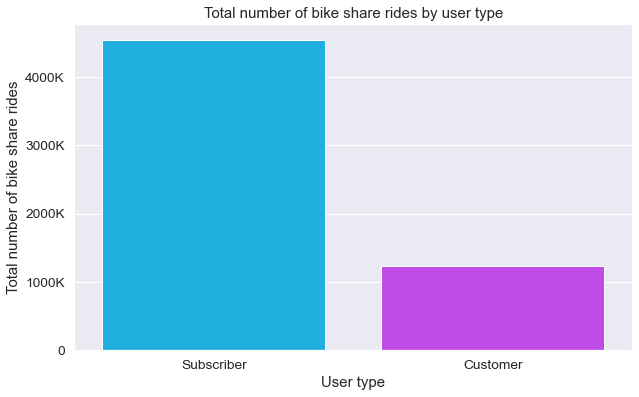

In [8]:
# Plot the breakdown of user type 

plt.figure(figsize = [10, 6])
plt.ticklabel_format(style='plain', axis='y')
colors = ['#00bfff', '#cc33ff']
sns.set_palette(colors)
ax = sns.countplot(data=df_clean, x='user_type', order=df_clean.user_type.value_counts().index)
ax.set(xlabel='User type', ylabel='Total number of bike share rides')
plt.title('Total number of bike share rides by user type')
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_format))
plt.show();


We can see that the majority of users are subscribers. One would think assume they would seem to be more consistent, ongoing users. I wonder how this will impact the behaviour... 

In [10]:
# Define typical as rides <= 60 minutes

typical = df_clean[df_clean['duration_minute'] <= 60]
typical

,duration_sec,start_time,end_time,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,user_type,start_time_month_name,start_time_month,start_time_weekday,start_time_day,start_time_hour,start_time_year_month,start_time_year,duration_minute
0,598,2018-02-28 23:59:47.097,2018-03-01 00:09:45.187,284.0,37.784872,-122.400876,114.0,37.764478,-122.402570,1035,Subscriber,February,2,Wed,28,23,18-02,2018,9.966667
1,943,2018-02-28 23:21:16.495,2018-02-28 23:36:59.974,6.0,37.804770,-122.403234,324.0,37.788300,-122.408531,1673,Customer,February,2,Wed,28,23,18-02,2018,15.716667
4,885,2018-02-28 23:15:12.858,2018-02-28 23:29:58.608,308.0,37.336802,-121.894090,297.0,37.322980,-121.887931,1839,Subscriber,February,2,Wed,28,23,18-02,2018,14.750000
5,921,2018-02-28 23:14:19.170,2018-02-28 23:29:40.437,312.0,37.329732,-121.901782,288.0,37.350964,-121.902016,2656,Customer,February,2,Wed,28,23,18-02,2018,15.350000
6,277,2018-02-28 23:21:49.274,2018-02-28 23:26:27.222,316.0,37.330165,-121.885831,310.0,37.335885,-121.885660,1616,Subscriber,February,2,Wed,28,23,18-02,2018,4.616667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5780380,480,2019-02-01 00:04:49.724,2019-02-01 00:12:50.034,27.0,37.788059,-122.391865,324.0,37.788300,-122.408531,4832,Subscriber,February,2,Fri,1,0,19-02,2019,8.000000
5780381,313,2019-02-01 00:05:34.744,2019-02-01 00:10:48.502,21.0,37.789625,-122.400811,66.0,37.778742,-122.392741,4960,Subscriber,February,2,Fri,1,0,19-02,2019,5.216667
5780382,141,2019-02-01 00:06:05.549,2019-02-01 00:08:27.220,278.0,37.331932,-121.904888,277.0,37.333658,-121.908586,3824,Subscriber,February,2,Fri,1,0,19-02,2019,2.350000
5780383,139,2019-02-01 00:05:34.360,2019-02-01 00:07:54.287,220.0,37.811351,-122.273422,216.0,37.817827,-122.275698,5095,Subscriber,February,2,Fri,1,0,19-02,2019,2.316667


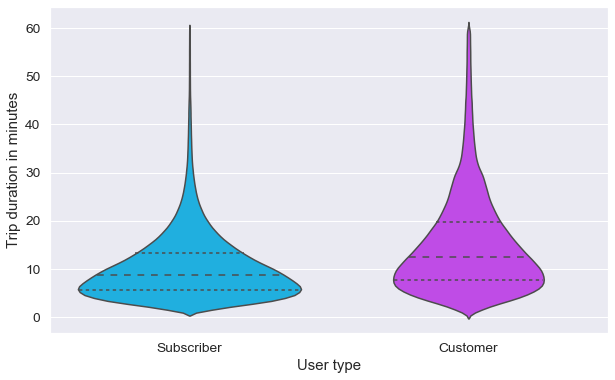

In [11]:
# Look at the distribution between subscribers and customers

plt.figure(figsize = [10, 6])
colors = ['#00bfff', '#cc33ff']
sns.set_palette(colors)
sns.violinplot(data=typical, x='user_type', y='duration_minute', inner='quartile')
plt.xlabel('User type')
plt.ylabel('Trip duration in minutes')
plt.show();


If we look at the distribution of trip duration for both subscribers and customers, we can see an interesting piece of insight. 

The distribution for subscriber is much narrower, suggesting that subscribers take short, sharp trips. 

On the other hand, the distribution for customers is wider, which would suggest that one-off customers take more variety of trips – of course, some short, but also some longer ones too. 

## Weekends are for Netflix and chill! 

When Saturday comes, are you more likely to opt for the bike or for the TV remote? I thought it would be interesting to explore usage trends for weekdays and weekends to see if there's any particular insights here for us. 

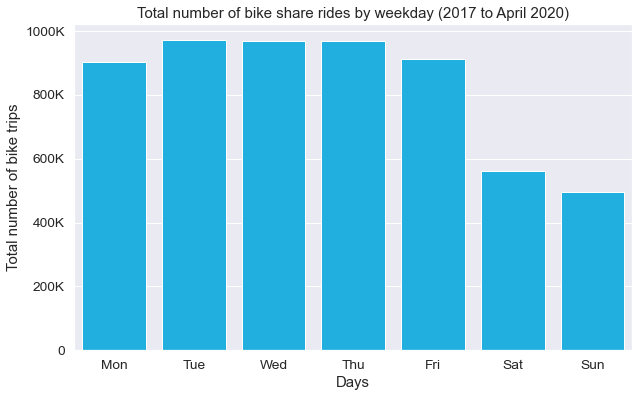

In [6]:
# Weekday bike share rides

plt.figure(figsize = [10, 6])
plt.ticklabel_format(style='plain', axis='y')
weekday = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax = sns.countplot(data=df_clean, x='start_time_weekday', color = 'deepskyblue', order=weekday)
ax.set(xlabel='Days', ylabel='Total number of bike trips')
plt.title('Total number of bike share rides by weekday (2017 to April 2020)')
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_format))
plt.show();


We can see that there is some kind of weekend effect at play. Bike share rides drop off significantly on weekends as compared to weekdays. 

I wonder if this is the case for subscribers and customers alike. 

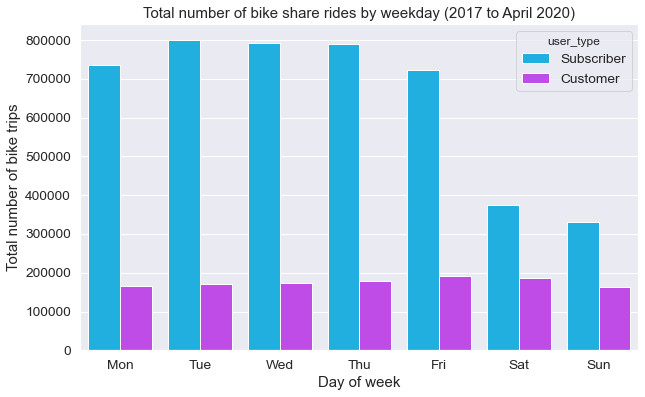

In [7]:
# Weekday bike share rides

plt.figure(figsize = [10, 6])
weekday = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
colors = ["#00bfff", "#cc33ff"]
sns.set_palette(colors)
sns.countplot(data=df_clean, x='start_time_weekday', order=weekday, hue='user_type')
plt.xlabel('Day of week')
plt.ylabel('Total number of bike trips')
plt.title('Total number of bike share rides by weekday (2017 to April 2020)')
plt.show();


There are appears to be more consistency in the bike trips for customers across weekdays and the weekend. 

On the other hand, the weekend effect drop off is quite clear for subscribers, indicating that perhaps they are using the ride share service predominantly for commute purposes, and... I'll take a guess (without the data to support it), but perhaps they're making the most of a more relaxing and leisurely weekend instead of getting on the bike again! 

In [20]:
# Set up for heatmap

plt.suptitle('Hourly usage throughout the week by user type')

df_clean['start_time_weekday'] = pd.Categorical(df_clean['start_time_weekday'], 
                                                categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], 
                                                ordered=True)



<Figure size 432x288 with 0 Axes>

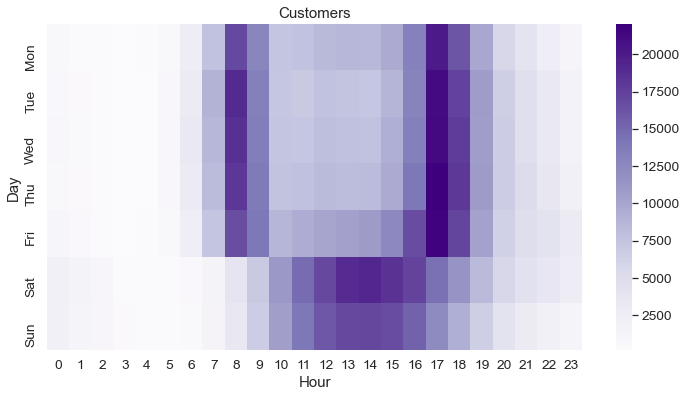

In [21]:
# Customer heatmap

plt.figure(figsize=(12,6))
customers = df_clean.query('user_type == "Customer"')
customer_count = customers.groupby(['start_time_weekday', 'start_time_hour']).size()
customer_count = customer_count.reset_index(name='count')
customer_count = customer_count.pivot(index='start_time_weekday', columns='start_time_hour', values='count')
midpoint = (customer_count.values.max() - customer_count.values.min()) / 2
sns.heatmap(customer_count, cmap='Purples', center=midpoint)
plt.title('Customers', loc='center')
plt.xlabel('Hour')
plt.ylabel('Day')

plt.show();

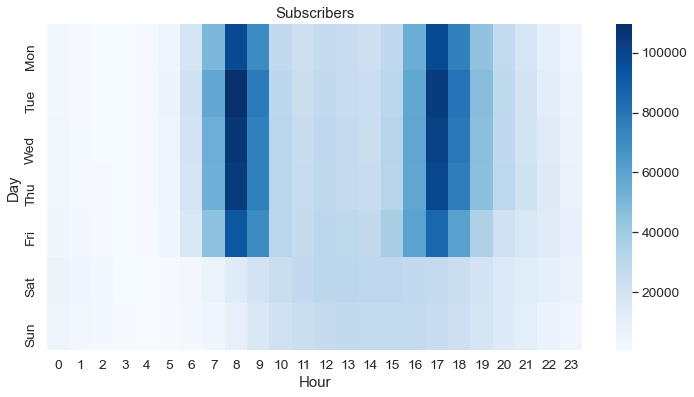

In [22]:
# Subscriber heatmap

plt.figure(figsize=(12,6))
subscribers = df_clean.query('user_type == "Subscriber"')
subsciber_count = subscribers.groupby(['start_time_weekday', 'start_time_hour']).size()
subsciber_count = subsciber_count.reset_index(name='count')
subsciber_count = subsciber_count.pivot(index='start_time_weekday', columns='start_time_hour', values='count')
midpoint = (subsciber_count.values.max() - subsciber_count.values.min()) / 2
sns.heatmap(subsciber_count, cmap='Blues', center=midpoint)
plt.title('Subscribers', loc='center')
plt.xlabel('Hour')
plt.ylabel('Day')

plt.show();

Let's bring it all together now. We can see from the heatmaps that whilst customers do prefer for an early morning / late afternoon ride, they are also amenable to a middle of the day cruise, and especially do like a ride on the weekend. 

In contrast, subscribers are quite regimented in their ride habits. They are like clockwork – a short ride in the morning, and short ride home in the evening. There is a clear rest on weekends. 

## COVID-19 begins

By the nature of the data range of this dataset, we have captured some of the early data right at the onset of the COVID-19 restrictions which we are still living through at the time of writing. What do the early indicators show? 

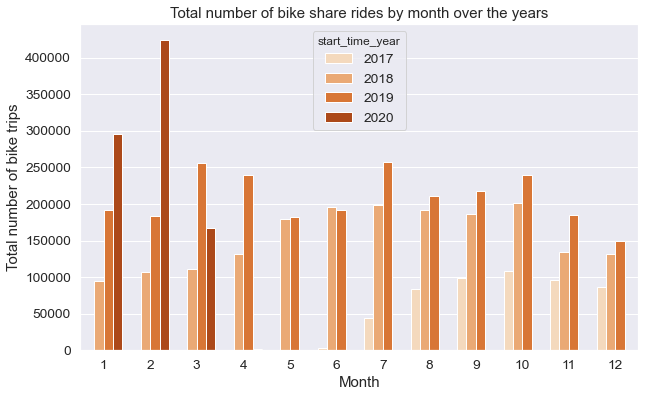

In [13]:
# Monthly bike share rides, by year

plt.figure(figsize = [10, 6])
sns.countplot(data=df_clean, x='start_time_month', palette='Oranges', hue='start_time_year')
plt.title('Total number of bike share rides by month over the years')
plt.ylabel('Total number of bike trips')
plt.xlabel('Month')
plt.show();


If we look at year-on-year monthly trends, we can see that there has been consistent growth in the Ford GoBike service. In particular, 2020 got off to a booming start with rapid growth and big ride numbers. This all came to a grinding halt, with a significant drop off in March 2020, coinciding with COVID-19 restrictions globally. It would be interesting to extend this study further and look at the patterns during the COVID-19 isolation period, and as we embark to a path of recovery and a hopeful return to some kind of normality. 

## Summary

> I hope you enjoyed this brief dive into the Ford GoBike data, and I hope you've learned a thing or two. To get some more insight from this area, I would love to continue the analysis beyond April 2020 and look to the patterns and behaviour in this new world amid COVID-19. 
